<a href="https://colab.research.google.com/github/henilp105/FMML2022-henilp105/blob/main/Project_lab_17.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

This Entire Experiment has been executed by Henil Panchal .

FMML 2022 ID: fmml20211022@ihub-data.iiit.ac.in

# Project Convolutional Neural Networks - Lab 17

We have used CNNs for image data. Now, one can ask: Can we use CNNs for other data modality, like text or audio? The answer is YES. CNNs can be used for non-image data as well, including text and audio. When using Naive Bayes and KNN we represent our text as a vector. With CNNs, it is similar. We pass the 1D input to our model. In case of audio, the numbers in vectors would represent an audio signal. In this lab exercise, we will see how we can use CNNs with audio data. We will perform speech command recognition by training an audio classifer network with speech command dataset. We will be using torchaudio module from Pytorch to handle audio.

***You have to answer the exercise questions and fill in the code where TODO is written.***

## Speech Command Recognition with torchaudio
First, let’s install and import the [torchaudio](https://pytorch.org/audio/stable/index.html) package. We will also install pydub package to be used later. (for an interactive demo at the end)




In [1]:
!pip install torchaudio pydub

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
# Import other required packages
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchaudio
from torchaudio.datasets import SPEECHCOMMANDS
from torch.utils.data import DataLoader,random_split,Dataset


import matplotlib.pyplot as plt
import IPython.display as ipd
from tqdm.notebook import tqdm
import os
import numpy as np

In [3]:
# Device configuration (whether to run on GPU or CPU)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [4]:
# Set seeds for reproducibility
seed = 0
# np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.backends.cudnn.deterministic = True

### Speech Commands Dataset
This dataset consists of 105,829 one-second long utterances of
35 words. The words were recorded by 2,618 different speakers. This audio dataset of spoken words was designed to help train and evaluate keyword spotting systems. Its primary goal is to provide a way to build and test small models that detect when a single word is spoken, from a set of target words, with as few false positives as possible from background noise or unrelated speech. Each utterance in the dataset is stored as WAVE format file. The dataset was introduced in [this paper](https://arxiv.org/abs/1804.03209).

Pytorch's torchaudio module provides utilities to work with audio datasets, speech commands dataset being one of them. This is large dataset, so for reducing the dataset loading and training time, we provide a smaller version containing 10 classes of the original dataset. We will still use the 'SPEECHCOMMANDS' from the torchaudio to load the dataset.

Let's download the modified dataset.

In [5]:
# Download the dataset
!gdown --id 14epafxPS5If_XZMQXGk_OmcgRvEVNwFZ

/usr/local/lib/python3.7/dist-packages/gdown/cli.py:131: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  category=FutureWarning,
Downloading...
From: https://drive.google.com/uc?id=14epafxPS5If_XZMQXGk_OmcgRvEVNwFZ
To: /content/speech_dataset.zip
100% 404M/404M [00:01<00:00, 210MB/s]


In [6]:
# Unzip the dataset archive
!unzip -q speech_dataset.zip

We will use the torchaudio dataset class to load our version of speech dataset. To do this, we will pass the path to our archive as argument.

In [7]:
train_data = torchaudio.datasets.SPEECHCOMMANDS('./' , url = 'speech_commands_v0.02', 
                                       folder_in_archive= 'speech_dataset', subset='training', download = False)
val_data = torchaudio.datasets.SPEECHCOMMANDS('./' , url = 'speech_commands_v0.02', 
                                       folder_in_archive= 'speech_dataset', subset='validation', download = False)
test_data = torchaudio.datasets.SPEECHCOMMANDS('./' , url = 'speech_commands_v0.02', 
                                       folder_in_archive= 'speech_dataset', subset='testing', download = False)

A data point in the SPEECHCOMMANDS dataset is a tuple made of a waveform
(the audio signal), the sampling rate, the utterance (label), the ID of
the speaker, the number of the utterance. Let's visualize the raw form of audio waveform.




Shape of waveform: torch.Size([1, 16000])
Sample rate of waveform: 16000


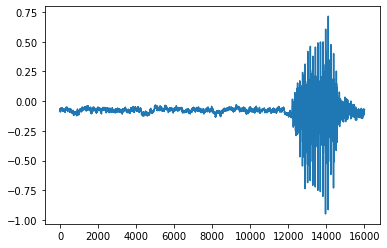

In [8]:
waveform, sample_rate, label, speaker_id, utterance_number = train_data[0]

print("Shape of waveform: {}".format(waveform.size()))
print("Sample rate of waveform: {}".format(sample_rate))

plt.plot(waveform.t().numpy());

Let's print the labels in our dataset. These are the speech commands said by the speakers.

In [9]:
classes = sorted(list(set(datapoint[2] for datapoint in train_data)))
print(classes)

['backward', 'bed', 'bird', 'cat', 'follow', 'forward', 'happy', 'learn', 'tree', 'visual']


Let's listen to a few samples

In [10]:
waveform, sample_rate, label, *_ = train_data[1]
print(label)
ipd.Audio(waveform.numpy(), rate=sample_rate)

backward


In [11]:
waveform, sample_rate, label, *_ = train_data[-1]
print(label)
ipd.Audio(waveform.numpy(), rate=sample_rate)

visual


For the sake of simplicity, we are not applying transformations to the dataset and we will use it in its raw form. In practical scenarios, we may need to apply transforms. For example, we can downsample the audio for faster processing without losing too much of the classification power. It is common for some datasets though to have to reduce the number of channels (say from stereo to mono) by either taking the mean along the channel dimension, or simply keeping only one of the channels. Since SpeechCommands uses a single channel for audio, this is not needed here. You can look at the transforms you can apply in the references section at the end.

We will drop the waveform samples in training and testing sets that don't have length as 16000. We do this to ensure same length of all samples. There are other ways to deal with this (e.g. resampling to fixed shape) but for now, we will just drop those samples. (Number of dropped samples is not very large)

In [12]:
# This function will retain the samples in data with fixed length of l
def retain_samples(data, l=16000):
  x = []
  y = []
  for i in range(0,len(data)):
      if data[i][0].shape == torch.Size([1, l]):
          x.append(data[i][0])
          y.append(data[i][2])
  print('Total samples: {} Retained samples: {}'.format(len(data), len(x)))
  return x, y

print('Training data---')
trainx, trainy = retain_samples(train_data)
print('Validation data---')
valx, valy = retain_samples(val_data)
print('Testing data---')
testx, testy = retain_samples(test_data)

Training data---
Total samples: 14438 Retained samples: 12707
Validation data---
Total samples: 1651 Retained samples: 1433
Testing data---
Total samples: 1800 Retained samples: 1618


Let's create a custom dataset class to load the above waveforms data after discarding the unequal length samples with labels. 

In [13]:
class SpeechDataset(Dataset):
    
    def _init_(self, data, labels, list_dir,transform=None):
        self.data = data #TODO
        self.labels = labels # TODO
        self.label_dict = list_dir # TODO
        self.transform = transform #TODO
            
    def _len_(self):
        return len(self.data) # TODO
    
    def _getitem_(self,idx):
        waveform = self.data[idx]
        
        if self.transform != None:
            waveform = self.transform(waveform)

        if self.labels[idx] in self.label_dict:
            out_labels = self.label_dict.index(self.labels[idx])
            

        return waveform, out_labels

In [14]:
train_dataset= random_split(Dataset, [round(len(Dataset).8), round(len(Dataset).2)])  #TODO
val_dataset= SpeechDataset(valx, valy, classes)
test_dataset= random_split(Dataset, [round(len(Dataset).8), round(len(Dataset).2)]) # TODO

# Data loaders
trainloader = torch.utils.data.DataLoader(train_dataset, batch_size=100, shuffle=True)
valloader = torch.utils.data.DataLoader(val_dataset, batch_size=100, shuffle=False)
testloader = torch.utils.data.DataLoader(test_dataset, batch_size=100, shuffle=True) # TODO

SyntaxError: ignored

### Define model
As the data is one-dimensional, we will use 1D convolutions. Here, we will also explore the use of 'Dropout' layer.

#### Dropout
Dropout is a regularization method where during training, some layer outputs are randomly ignored or "dropped out." This has the effect of making the layer look-like and be treated-like a layer with a different number of nodes and connectivity to the prior layer. By dropping a unit out, we mean temporarily removing it from the network, along with all its incoming and outgoing connections. Here, a new hyperparameter is introduced that specifies the probability at which outputs of the layer are dropped out. It randomly zeroes some of the elements of the input to the layer with probability p using samples from a Bernoulli distribution. This has proven to be an effective technique for regularization. When using dropout regularization, it is possible to use larger networks with less risk of overfitting. We will use [nn.Dropout](https://pytorch.org/docs/stable/generated/torch.nn.Dropout.html) from Pytorch.

In [ ]:
class AudioClassifier(nn.Module):
    def _init_(self, numb_class):
        super(AudioClassifier,self)._init_()
        
        self.conv1 = nn.Conv1d(in_channels=1,out_channels=8,kernel_size=13,stride=1)
        self.dropout1 = nn.Dropout(0.3) 
    
        self.conv2 = nn.Conv1d(in_channels= 8,out_channels=16,kernel_size=11,stride=1) # TODO
        self.dropout2 = nn.Dropout(0.3)
        
        self.conv3 = nn.Conv1d(in_channels= 16,out_channels=32,kernel_size=9,stride=1) # TODO
        self.dropout3 = nn.Dropout(0.3)
        
        self.conv4 = nn.Conv1d(in_channels=13,out_channels=64,kernel_size=7,stride=1) # TODO
        self.dropout4 = nn.Dropout(0.3)
        
        self.fc1 = nn.Linear(0.3)
        self.dropout5 = nn.Dropout(0.3)
        self.fc2 = nn.Linear(256,128)
        self.dropout6 = nn.Dropout(0.3)
        self.fc3 = nn.Linear(128,num_class)
        
    def forward(self, x):
        
        x = F.max_pool1d(F.relu(self.conv1(x)),kernel_size=3)
        x = self.dropout1(x)
        
        x = F.max_pool1d(F.relu(self.conv2(x)),kernel_size=3)
        x = self.dropout2(x)
        
        x = F.max_pool1d(F.relu(self.conv3(x)),kernel_size=3)
        x = self.dropout3(x)
        
        x = F.max_pool1d(F.relu(self.conv4(x)),kernel_size=3)
        x = self.dropout4(x)
        
        x = F.relu(self.fc1(x.reshape(-1,x.shape[1] * x.shape[2])))
        x = self.dropout5(x)
        
        x = F.relu(self.fc2(x))
        x = self.dropout6(x)
        
        x = self.fc3(x)
        
        return x  # TODO

Define training and testing helper functions

In [ ]:
def train(model,trainloader,optim,scheduler,criterion,epoch):
    print("Training")
    model.train()
    train_loss = 0
    total = 0
    total_correct = 0
    
    for inputs, targets in tqdm(trainloader):
        inputs = inputs.to(device)
        targets = targets.to(device)
        
        optim.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs,targets)
        loss.backward()
        optim.step()
        scheduler.step()
        
        train_loss += loss.item()
        _,predicted = torch.max(outputs.data,1)
        total_correct += (predicted == targets).sum().item()
        total += targets.size(0)
    
    acc = 100. * total_correct / total
    print("Epoch: {}  Loss: {:.2f} Accuracy {:.2f} ".format(epoch+1,train_loss/len(trainloader), acc))
    return train_loss/len(trainloader), acc
    
def test(model,testloader,optim,criterion,epoch):
    print("validation")
    model.eval()
    test_loss,total,total_correct = 0,0,0
    
    for inputs, targets in tqdm(testloader):
        inputs, targets = inputs.to(device), targets.to(device)
        outputs = model(inputs)
        loss = criterion(outputs, targets)

        test_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += targets.size(0)
        total_correct += (predicted == targets).sum().item()

    acc = 100. * total_correct / total
    print("\nEpoch #{} Loss: {:.4f} Accuracy: {:.2f}".format(epoch+1, test_loss/len(testloader), acc))
    return test_loss/len(testloader), acc

In [ ]:
model = AudioClassifier(numb_class = 100)
model = model.to(device)

### Define training parameters
We will use [Adam optimizer](https://pytorch.org/docs/stable/generated/torch.optim.Adam.html?highlight=adam#torch.optim.Adam). In normal SGD the learning rate has an equivalent type of effect for all the parameters of the model. Whereas, Adam adaptively selects a separate learning rate for each parameter. For more information on this optimizer, check out the resources section.

Here, we are using [OneCycleLR scheduler](https://pytorch.org/docs/stable/generated/torch.optim.lr_scheduler.OneCycleLR.html). It sets the learning rate of each parameter group according to the 1cycle learning rate policy. The 1cycle policy anneals the learning rate from an initial learning rate to some maximum learning rate and then from that maximum learning rate to some minimum learning rate much lower than the initial learning rate.

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(),lr=# TODO) # see what value works best # TODO
scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr=0.001,
                                              steps_per_epoch=int(len(trainloader)),
                                              epochs=20,
                                              anneal_strategy='linear') 

### Training

In [ ]:
num_epochs= 25 # TODO see what value works best
train_losses, train_acc = [], []
val_losses, val_acc = [], []

for epoch in range(0, num_epochs):
    loss, acc = train(model,trainloader,optimizer,scheduler,criterion,epoch)
    train_losses.append(loss)
    train_acc.append(acc)

    loss, acc = test(model,valloader,optimizer,criterion,epoch)
    val_losses.append(loss)
    val_acc.append(acc)

In [ ]:
fig = plt.figure(figsize=(10,4))
ax = fig.add_subplot(1,2, 1)
ax.plot(np.arange(1,len(train_losses)+1),train_losses)
ax.plot(np.arange(1,len(val_losses)+1),val_losses)
plt.xlabel('Loss')
plt.ylabel('Epochs')
plt.legend(['Train Loss', 'Val Loss'])


ax = fig.add_subplot(1,2, 2)
ax.plot(np.arange(1,len(train_acc)+1),train_acc)
ax.plot(np.arange(1,len(val_acc)+1),val_acc)
plt.xlabel('Accuracy')
plt.ylabel('Epochs')
plt.legend(['Train Acc', 'Val Acc'])
plt.show()

#### Evaluate the model

In [ ]:
loss, acc = test(model,testloader,optimizer,criterion,0)

Now, try with your own recordings of speaking a word from the labels!
For example, say 'backward' while executing the cell below. The below cell will record one second of audio and load the sample in the output cell for you to hear it. We can also easily load a single audio file using torchaudio.load() method. It returns the waveform and its sampling rate. You don't need to bother much with the audio recording code.




In [ ]:
# Helper function to predict the class of audio signal with the model
def predict(tensor):
    tensor = tensor.to(device)
    output = model(tensor.unsqueeze(0))

    # index of max value activation
    _, predicted = torch.max(output.data, 1)
    return classes[predicted[0]]

In [ ]:
from google.colab import output as colab_output
from base64 import b64decode
from io import BytesIO
from pydub import AudioSegment


RECORD = """
const sleep  = time => new Promise(resolve => setTimeout(resolve, time))
const b2text = blob => new Promise(resolve => {
  const reader = new FileReader()
  reader.onloadend = e => resolve(e.srcElement.result)
  reader.readAsDataURL(blob)
})
var record = time => new Promise(async resolve => {
  stream = await navigator.mediaDevices.getUserMedia({ audio: true })
  recorder = new MediaRecorder(stream)
  chunks = []
  recorder.ondataavailable = e => chunks.push(e.data)
  recorder.start()
  await sleep(time)
  recorder.onstop = async ()=>{
    blob = new Blob(chunks)
    text = await b2text(blob)
    resolve(text)
  }
  recorder.stop()
})
"""


def record(seconds=1):
    display(ipd.Javascript(RECORD))
    print(f"Recording started for {seconds} seconds.")
    s = colab_output.eval_js("record(%d)" % (seconds * 1000))
    print("Recording ended.")
    b = b64decode(s.split(",")[1])

    fileformat = "wav"
    filename = f"_audio.{fileformat}"
    AudioSegment.from_file(BytesIO(b)).export(filename, format=fileformat)
    return torchaudio.load(filename)


waveform, sample_rate = record()
ipd.Audio(waveform.numpy(), rate=sample_rate)

We will now use our model to classify the above recording. For this, first we need to check the length of waveform if it's 16000 and change it if not. Resampling will reduce the length and then we can pad the sample with zeros to 16000 if required. 

In [ ]:
# Model in eval mode
model.eval()

print('Original sample rate: ', sample_rate)
new_sample_rate = 16000
# Create a transform and apply to recorded waveform. This will reduce the sample rate close to our desired rate (16000)
transform = torchaudio.transforms.Resample(orig_freq=sample_rate, new_freq=new_sample_rate)
transformed = transform(waveform)
print('New sample rate: ', transformed.shape[1])

# Pad with zeros by creating an empty array of 16000 length and place the transformed array into it
# To avoid errors with transformed wave sample rate > 16000, we'll consider starting 16000 values (may happen for random audio)
padded_waveform = torch.zeros((1,16000))
if transformed.shape[-1] < 16000:
  padded_waveform[:, :transformed.shape[-1]] = transformed
else:
  padded_waveform[:, :16000] = transformed[:,:16000]

print('Predicted: ', predict(padded_waveform))

## Exercises

Q 1: Was any of your recording predicted wrong? If yes, what was the input audio and predicted label and, why do you think model couldn't recognise your word?

Answer: no, they were predicted correctly

Q 2: Here, we used audio features as 1D input of length 16000. As the features are just numbers, what if we reshape each sample into 2D shape, for eg. 200 x 80 and then use Conv2D instead of Conv1D? Will this work?

Answer: yes, it will work!


Q 3: What would happen if we remove the Dropout layers from the network? Report the test accuracy and loss. 

Answer: usually,input variables and/or activations are usually removed for "dropouts". it simulates an extensive different network and the nodes end up beong very robust towards the inputs


Q 4: What happens if you say combination of two words for eg: 'happybird'? Does the model recognise the first word? Try with the recording. What was the predicted output label?

Answer: it recognizes the emotion - happy from the audio

Q 5: Try training with basic 'StepLR' scheduler and see if the model loses performance or not. What performance did you achieve?

Answer: 

Q 6: What is your test set accuracy?

Answer:

## References and Additional Resources


*   [Torchaudio datasets](https://pytorch.org/audio/stable/datasets.html)
*   [Speech commands recognition with torchaudio tutorial - Pytorch](https://pytorch.org/tutorials/intermediate/speech_command_recognition_with_torchaudio.html)
*   [Article on Speech Command Classification](https://medium.com/@aminul.huq11/speech-command-classification-using-pytorch-and-torchaudio-c844153fce3b)
*   [Dropout regularization](https://machinelearningmastery.com/dropout-for-regularizing-deep-neural-networks/)
*   [CNN for Audio Classification](https://towardsdatascience.com/cnns-for-audio-classification-6244954665ab)
*   [Spoken Digits Sound classification](https://medium.com/x8-the-ai-community/audio-classification-using-cnn-coding-example-f9cbd272269e)
*   [Sentiment Analysis with CNN](https://towardsdatascience.com/cnn-sentiment-analysis-1d16b7c5a0e7)
*   [Text classification using CNNs](https://medium.com/voice-tech-podcast/text-classification-using-cnn-9ade8155dfb9)
*   [Adam vs SGD optimizer](https://medium.com/@Biboswan98/optim-adam-vs-optim-sgd-lets-dive-in-8dbf1890fbdc)

